# Data Analysis for Dereks Paints

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import *
from scipy.stats import *

In [2]:
raw_data = pd.read_csv('/Users/isaiah/Downloads/data_sma.csv')
raw_data.head()

analysis_data = raw_data[[
    'Key', 
    'Batch No.',
    'Product Code', 
    'Description', 
    'Process/Step Name', 
    'Machine', 
    'Start Datetime', 
    'End Datetime', 
    'Process Duration (min)'
]].rename(columns={
    'Key': 'key',
    'Batch No.': 'batch_no',
    'Product Code': 'product_code',
    'Description': 'description',
    'Process/Step Name': 'step_name',
    'Machine': 'machine',
    'Start Datetime': 'start_time',
    'End Datetime': 'end_time',
    'Process Duration (min)': 'duration_min'
})
analysis_data.head()


,key,batch_no,product_code,description,step_name,machine,start_time,end_time,duration_min
0,f3c3k31NgpnvqIZaDuM99S,oLMc9CXMmw4YmaRfiR5TCf,RM2-ACX-40,DAVIES ACREEX MARKING YELLOW,PMWS Printing,NaN,4/19/2024 14:42:00,4/19/2024 14:43:00,1.0
1,oiIPn9M3acQY3LBNKFpnfO,oLMc9CXMmw4YmaRfiR5TCf,RM2-ACX-40,DAVIES ACREEX MARKING YELLOW,FG Transfer,NaN,5/7/2024 11:34:00,5/7/2024 14:33:00,179.0
2,txPWzoriKMuP4Le4ZUQOUo,hZCShlxunF00aENM9WmouD,RM2-ACX-21,DAVIES ACREEX CRYSTAL BLUE,Premix,HSM-1,5/9/2024 11:20:00,5/9/2024 11:35:00,15.0
3,c2A9zmR2vTHvfbnDogjUSv,hZCShlxunF00aENM9WmouD,RM2-ACX-21,DAVIES ACREEX CRYSTAL BLUE,Grind (Part A),BKM-11,5/10/2024 7:30:00,5/10/2024 12:30:00,300.0
4,IYjn62HQLzvLszapEjZqzF,hZCShlxunF00aENM9WmouD,RM2-ACX-21,DAVIES ACREEX CRYSTAL BLUE,Grits Check,BKM-11,5/10/2024 12:30:00,5/10/2024 14:30:00,120.0


# Group by Batch

In [4]:
batch_grouped = analysis_data.groupby('batch_no')['duration_min'].sum().reset_index()
print(batch_grouped.describe())
batch_grouped.head()

       duration_min
count    104.000000
mean    1667.903846
std     5191.746006
min        1.000000
25%      602.750000
50%      819.000000
75%     1186.250000
max    39191.000000


,batch_no,duration_min
0,-gjFgpJ1d34fQhrswhECYf,1632.0
1,-zEn2HtTmC4_aBm8EbD9ne,37545.0
2,0UHVM07G5g49uHwPUjIX49,920.0
3,23_B5MLw5z4Perd8XapY_1,2.0
4,26xwngMX1C4gmj8IPo79x6,945.0


# Observe the IQR Range
We are going to use the data here to model our distribution

In [9]:
q1 = batch_grouped['duration_min'].quantile(0.25)
q3 = batch_grouped['duration_min'].quantile(0.75)

# Filter for batches within IQR range
iqr_data = batch_grouped[(batch_grouped['duration_min'] >= q1) & 
                          (batch_grouped['duration_min'] <= q3)]

iqr_data.shape


(52, 2)

# Representative Data
- This is the data we will be using to identify the distributions
- Choosing middle 50% of data as it:
    - Avoids short batches (which may be incomplete or trivial)
    - Avoids long extreme batches (likely delays or special cases)
    - Gives stable base for simulation and distribution fitting

In [11]:
# Get the list of representative batch numbers
representative_batches = iqr_data['batch_no'].unique()

# Filter the original analysis_data using those batch numbers
representative_data = analysis_data[analysis_data['batch_no'].isin(representative_batches)]

representative_data.head()


,key,batch_no,product_code,description,step_name,machine,start_time,end_time,duration_min
42,TErMWFbpvJUxH0wis5hmMf,K5POC2gbWd4Bi4VNG56Bxf,RM2-ACX-60,DAVIES ACREEX BLACK,Premix,HSM-1,5/29/2024 9:15:00,5/29/2024 9:30:00,15.0
43,ojCqiC2XiHU9xNnnXeNqVH,K5POC2gbWd4Bi4VNG56Bxf,RM2-ACX-60,DAVIES ACREEX BLACK,Grind (Part A),BKM-5,5/29/2024 10:30:00,5/29/2024 15:30:00,300.0
68,gY8F5cMErTMktuetn3gsp5,K5POC2gbWd4Bi4VNG56Bxf,RM2-ACX-60,DAVIES ACREEX BLACK,PMWS Printing,BKM-5,6/4/2024 6:42:00,6/4/2024 6:43:00,1.0
69,ATsMBxDsnIBq1ezWEsk5zT,K5POC2gbWd4Bi4VNG56Bxf,RM2-ACX-60,DAVIES ACREEX BLACK,Load,PMX-11,6/2/2024 9:15:00,6/2/2024 9:25:00,10.0
70,JQTzyb7cwa8pKQT2JMTD9F,K5POC2gbWd4Bi4VNG56Bxf,RM2-ACX-60,DAVIES ACREEX BLACK,Grits Check,HSM-32,6/2/2024 8:15:00,6/2/2024 8:45:00,30.0


# Machine Summary per Batch and total duration based on steps taken

In [15]:
machine_batch_summary = representative_data.groupby(['batch_no', 'machine'])['duration_min'].sum().reset_index()
machine_batch_summary.head(10)

,batch_no,machine,duration_min
0,0UHVM07G5g49uHwPUjIX49,BKM-11,240.0
1,0UHVM07G5g49uHwPUjIX49,HSM-1,15.0
2,0UHVM07G5g49uHwPUjIX49,HSM-16,20.0
3,0UHVM07G5g49uHwPUjIX49,MX-3,410.0
4,0UHVM07G5g49uHwPUjIX49,PMX-3,45.0
5,0UHVM07G5g49uHwPUjIX49,PMX-4,190.0
6,26xwngMX1C4gmj8IPo79x6,BKM-11,360.0
7,26xwngMX1C4gmj8IPo79x6,HSM-2,15.0
8,26xwngMX1C4gmj8IPo79x6,MX-4,140.0
9,26xwngMX1C4gmj8IPo79x6,PMX-3,40.0


In [16]:
machine_batch_summary['machine_group'] = machine_batch_summary['machine'].str.split('-').str[0]
machine_batch_summary

,batch_no,machine,duration_min,machine_group
0,0UHVM07G5g49uHwPUjIX49,BKM-11,240.0,BKM
1,0UHVM07G5g49uHwPUjIX49,HSM-1,15.0,HSM
2,0UHVM07G5g49uHwPUjIX49,HSM-16,20.0,HSM
3,0UHVM07G5g49uHwPUjIX49,MX-3,410.0,MX
4,0UHVM07G5g49uHwPUjIX49,PMX-3,45.0,PMX
...,...,...,...,...
219,zf27NXBlBl4AISujveLxH1,BKM-16,510.0,BKM
220,zf27NXBlBl4AISujveLxH1,HSM-2,15.0,HSM
221,zf27NXBlBl4AISujveLxH1,MX-4,159.0,MX
222,zf27NXBlBl4AISujveLxH1,PMX-2,195.0,PMX


# Find all Minimum Service Times
This allows us to identify base processing time of each machine

In [36]:
print(machine_batch_summary[machine_batch_summary['machine_group'] == "BKM"].min())
print(machine_batch_summary[machine_batch_summary['machine_group'] == "PMX"].min())
print(machine_batch_summary[machine_batch_summary['machine_group'] == "MX"].min())
print(machine_batch_summary[machine_batch_summary['machine_group'] == "HSM"].min())

batch_no         0UHVM07G5g49uHwPUjIX49
machine                          BKM-11
duration_min                      120.0
machine_group                       BKM
dtype: object
batch_no         0UHVM07G5g49uHwPUjIX49
machine                          PMX-10
duration_min                       25.0
machine_group                       PMX
dtype: object
batch_no         0UHVM07G5g49uHwPUjIX49
machine                            MX-3
duration_min                       30.0
machine_group                        MX
dtype: object
batch_no         0UHVM07G5g49uHwPUjIX49
machine                           HSM-1
duration_min                        0.0
machine_group                       HSM
dtype: object


# Observe Machine Distributions

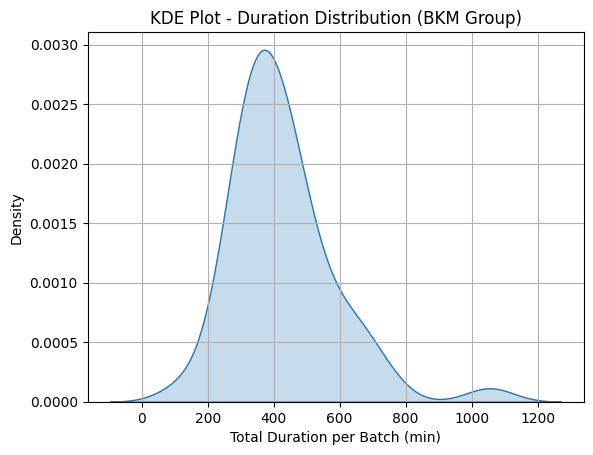

In [19]:
bkm_data = machine_batch_summary[machine_batch_summary['machine_group'] == 'BKM']

sns.kdeplot(bkm_data['duration_min'], fill=True)
plt.title('KDE Plot - Duration Distribution (BKM Group)')
plt.xlabel('Total Duration per Batch (min)')
plt.ylabel('Density')
plt.grid(True)
plt.show()


Shape: 0.3501070348361251, Location: 0, Scale: 401.6295964193655


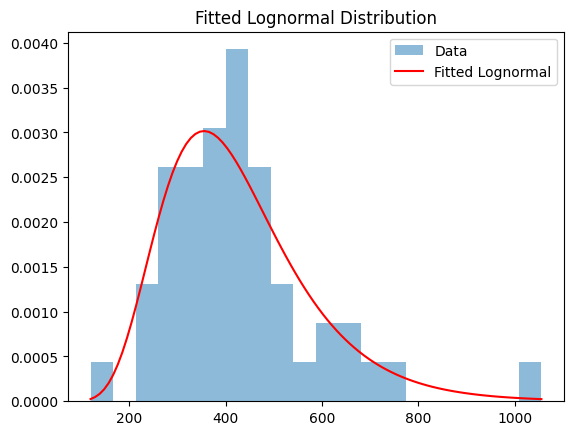

In [23]:
shape, loc, scale = lognorm.fit(bkm_data['duration_min'], floc=0)
print(f"Shape: {shape}, Location: {loc}, Scale: {scale}")

x = np.linspace(min(bkm_data['duration_min']), max(bkm_data['duration_min']), 100)
pdf = lognorm.pdf(x, shape, loc=loc, scale=scale)

plt.hist(bkm_data['duration_min'], bins=20, density=True, alpha=0.5, label='Data')
plt.plot(x, pdf, 'r-', label='Fitted Lognormal')
plt.legend()
plt.title("Fitted Lognormal Distribution")
plt.show()

In [26]:
machine_groups = machine_batch_summary['machine_group'].unique()

distributions = {
    'lognorm': lognorm,
    'weibull': weibull_min,
    'gamma': gamma,
    'expon': expon,
    'norm': norm
}

results = {}

for group in machine_groups:
    data = machine_batch_summary[machine_batch_summary['machine_group'] == group]['duration_min']
    data = data[data > 0]
    
    group_results = {}
    for name, dist in distributions.items():
        try:
            params = dist.fit(data, floc=0 if name != 'norm' else None)  # fix loc for others
            ll = dist.logpdf(data, *params).sum()
            group_results[name] = {'params': params, 'log_likelihood': ll}
        except:
            pass
    
    results[group] = group_results


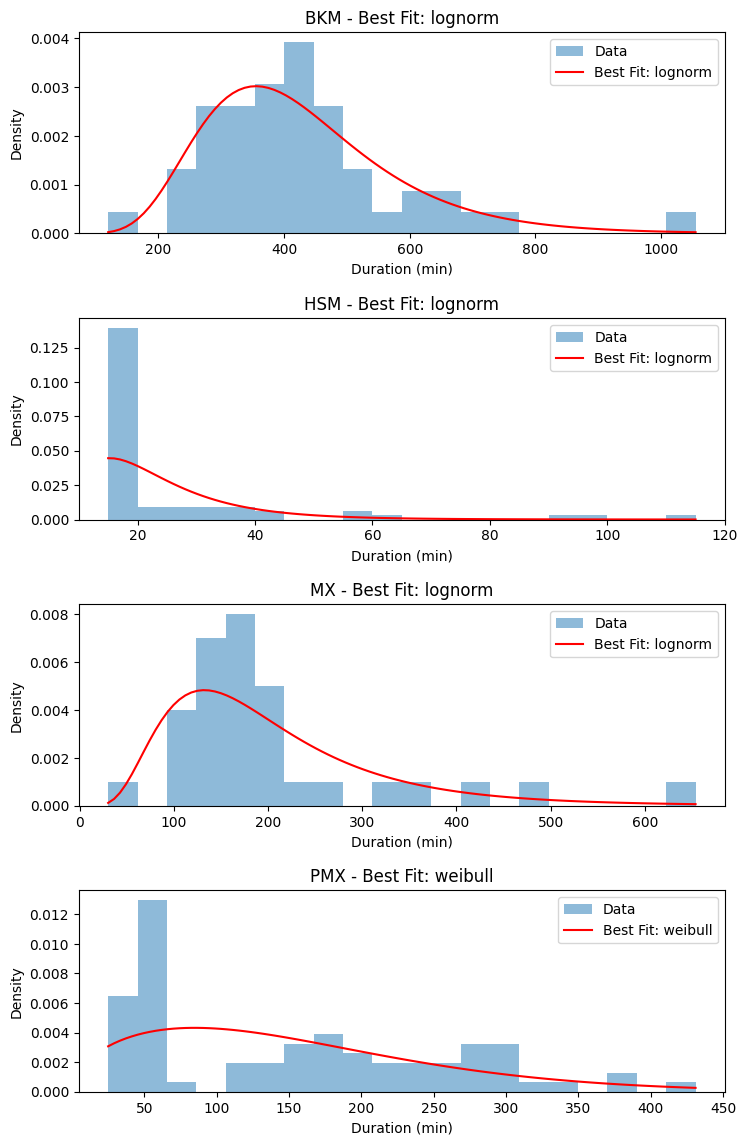

In [32]:
fig, axes = plt.subplots(nrows=len(machine_groups), figsize=(8, len(machine_groups) * 3))
fig.tight_layout(pad=4.0)

for i, group in enumerate(machine_groups):
    data = machine_batch_summary[machine_batch_summary['machine_group'] == group]['duration_min']
    data = data[data > 0]

    dist_results = results[group]
    if not dist_results:
        axes[i].set_title(f"{group} - No valid data")
        continue

    # Identify best fit
    best_dist_name, best_fit = max(dist_results.items(), key=lambda x: x[1]['log_likelihood'])
    dist_obj = distributions[best_dist_name]
    params = best_fit['params']

    # Plot histogram + best-fit PDF
    x = np.linspace(min(data), max(data), 100)
    pdf = dist_obj.pdf(x, *params)

    axes[i].hist(data, bins=20, density=True, alpha=0.5, label='Data')
    axes[i].plot(x, pdf, 'r-', label=f'Best Fit: {best_dist_name}')
    axes[i].set_title(f"{group} - Best Fit: {best_dist_name}")
    axes[i].set_xlabel("Duration (min)")
    axes[i].set_ylabel("Density")
    axes[i].legend()

plt.show()


In [29]:
best_fits = {}

for group, dist_results in results.items():
    if dist_results:
        # Get distribution with the highest log-likelihood
        best_dist = max(dist_results.items(), key=lambda x: x[1]['log_likelihood'])
        dist_name, dist_data = best_dist
        best_fits[group] = {
            'best_distribution': dist_name,
            'log_likelihood': dist_data['log_likelihood'],
            'params': dist_data['params']
        }

best_fits_df = pd.DataFrame.from_dict(best_fits, orient='index')
best_fits_df

,best_distribution,log_likelihood,params
BKM,lognorm,-311.882669,"(0.3501070348361251, 0, 401.6295964193655)"
HSM,lognorm,-246.931983,"(0.5127398690290498, 0, 19.89446980851758)"
MX,lognorm,-191.359448,"(0.5407646020399312, 0, 176.940837683652)"
PMX,weibull,-451.016570,"(1.5137881633738486, 0, 172.99472227694355)"


# Convert parameters to JaamSim ready simulation

In [30]:
jaamsim_ready = []

for group, row in best_fits_df.iterrows():
    dist = row['best_distribution']
    params = row['params']
    
    if dist == 'lognorm':
        shape, loc, scale = params
        mean = np.log(scale)  # NormalMean
        std = shape           # NormalStdDev
        scale_hrs = scale / 60

        jaamsim_ready.append({
            'Machine Group': group,
            'Distribution': 'LogNormal',
            'Location (h)': loc,
            'Scale (h)': round(scale_hrs, 3),
            'NormalMean': round(mean, 3),
            'NormalStdDev': round(std, 3)
        })

    elif dist == 'weibull':
        shape, loc, scale = params
        scale_hrs = scale / 60
        jaamsim_ready.append({
            'Machine Group': group,
            'Distribution': 'Weibull',
            'Location (h)': loc,
            'Scale (h)': round(scale_hrs, 3),
            'Shape': round(shape, 3)
        })

# Create final table
jaamsim_df = pd.DataFrame(jaamsim_ready)
jaamsim_df


,Machine Group,Distribution,Location (h),Scale (h),NormalMean,NormalStdDev,Shape
0,BKM,LogNormal,0,6.694,5.996,0.350,NaN
1,HSM,LogNormal,0,0.332,2.990,0.513,NaN
2,MX,LogNormal,0,2.949,5.176,0.541,NaN
3,PMX,Weibull,0,2.883,NaN,NaN,1.514
